In [253]:
import sys, os, glob
import numpy, scipy

def get_info_from_out_log(path):
    assert os.path.exists(path)

    data = []
    for out_log in  glob.glob(os.path.join(path, "**", "out.log"), recursive=True):
        d = {}
        kmesh = out_log.split("/")[4]
        kmesh = [int(x) for x in kmesh.split("-")]
        d["kmesh"] = numpy.prod(kmesh)
        d["method"] = "-".join(out_log.split("/")[5].split("-")[:-1])
        d["ncpu"] = int(out_log.split("/")[5].split("-")[-1])
        d["cell"] = out_log.split("/")[3]
        d["natm"] = 2 if d["cell"] == "diamond-prim" else 8
        d["path"] = out_log
        if "fftisdf-jy" in out_log:
            info = out_log.split("/")[7].split("-")
            d["k0"] = float(info[1]) if len(info) == 4  else None
            d["c0"] = float(info[3]) if len(info) == 4  else float(info[1])

        with open(out_log, "r") as f:
            table = []
            for line in f:
                if "CPU time" in line:
                    key_word = line.split()[3]
                    wall_time = line.split()[8]
                    d["t_" + key_word] = float(wall_time)

                if "###" in line:
                    table.append(line)

            d["table"] = table
            d["lines"] = f.readlines()

            if len(table) == 2:
                keys = table[0][3:].split(",")
                values = table[1][3:].split(",")
                for key, value in zip(keys, values):
                    d[key.strip()] = float(value.strip())

        data.append(d)

    return data

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"

def plot_error(data):
    ks = []
    cs = []
    kmesh = []

    for d in data:
        k0 = d.get("k0", None)
        c0 = d.get("c0", None)
        if k0 is not None and c0 is not None:
            ks.append(k0)
            cs.append(c0)
            kmesh.append(d["kmesh"])

    ks = numpy.array(ks)
    cs = numpy.array(cs)
    kmesh = numpy.array(kmesh)

    ks = numpy.unique(ks)
    cs = numpy.unique(cs)
    kmesh = numpy.unique(kmesh)

    fig, axs = plt.subplots(len(cs), 1, figsize=(6, 6), sharex=True)

    natm = data[0]["natm"]
    d0 = [d for d in data if d["method"] == "fftdf" and d["ncpu"] == 1]
    d1 = [d for d in data if d["method"] == "fftisdf-jy" and d["ncpu"] == 32 and d.get("k0", None) is not None]
    d2 = [d for d in data if d["method"] == "fftisdf-jy" and d["ncpu"] == 32 and d.get("k0", None) is None]

    for i, c0 in enumerate(cs):
        ax = axs[i]
        cell = d1[0]["cell"].split("-")
        ax.text(0.05, 0.80, f"$c_0 = {c0:.1f}$, %s %s" % (cell[1], cell[0]), transform=ax.transAxes, fontsize=14)
        ax.axhline(5e-5, color="grey", linestyle="--", alpha=0.5)
        ax.grid(True, which="major", alpha=0.5, linestyle="--", axis="x")

        x0 = [d["kmesh"] for d in d0]
        y0 = [d.get("e_tot", numpy.nan) for d in d0]
        x0 = numpy.array(x0)
        y0 = numpy.array(y0)
        m = numpy.argsort(x0)
        x0 = x0[m] * natm
        y0 = y0[m]

        x2 = [d["kmesh"] for d in d2 if d.get("c0", None) == c0]
        y2 = [d.get("e_tot", numpy.nan) for d in d2 if d.get("c0", None) == c0]

        x2 = numpy.array(x2)
        y2 = numpy.array(y2)
        m = numpy.argsort(x2)
        x2 = x2[m] * natm
        y2 = y2[m]

        xx = numpy.log2(x0)
        yy = abs(y0 - y2) + 1e-6
        ax.semilogy(xx, yy / natm, label=f"default", color="b", linestyle="-", marker="s", markersize=4)

        for k0 in ks:
            x1 = [d["kmesh"] for d in d1 if d["k0"] == k0 and d["c0"] == c0]
            y1 = [d.get("e_tot", numpy.nan) for d in d1 if d["k0"] == k0 and d["c0"] == c0]
            x1 = numpy.array(x1)
            y1 = numpy.array(y1)
            m = numpy.argsort(x1)
            x1 = x1[m] * natm
            y1 = y1[m]

            xx = numpy.log2(x1)
            yy = abs(y0 - y1) + 1e-6
            ax.semilogy(xx, yy / natm, label=f"$k_0={k0}$", linestyle="-.", marker="s", markersize=4)
            # print(xx, yy / natm)
            
            # ax.set_xlim(x0[0], x0[-1])
            ax.set_ylim(8e-7, 0.1)
            ax.set_yticks([1e-6, 1e-4, 1e-2])

    axs[0].legend(
        loc="upper left",
        bbox_to_anchor=(0, 1.6),
        ncol=3, fontsize=12,
        frameon=False, columnspacing=4.0
    )
    fig.tight_layout()

    axs[-1].set_xlabel(r"$N_{\mathrm{atom}}$", fontsize=12)
    for ax in axs:
        ax.set_ylabel("Energy error", fontsize=12)

    xx = [i for i in range(3, 8)]
    axs[-1].set_xticks(xx)
    axs[-1].set_xticklabels([r"$2^{%d}$" % i for i in xx])
    axs[-1].set_xlim(xx[0], xx[-1])

    plt.show()



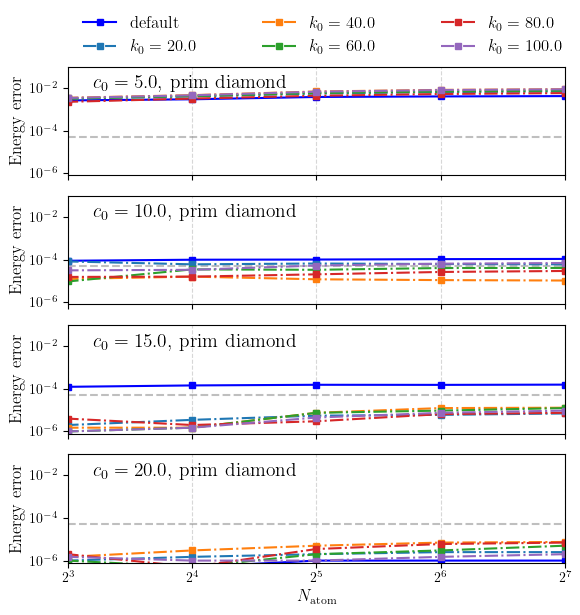

In [254]:
diamond_prim_k = get_info_from_out_log("../work/run-scf-kpt/diamond-prim")
plot_error(diamond_prim_k)

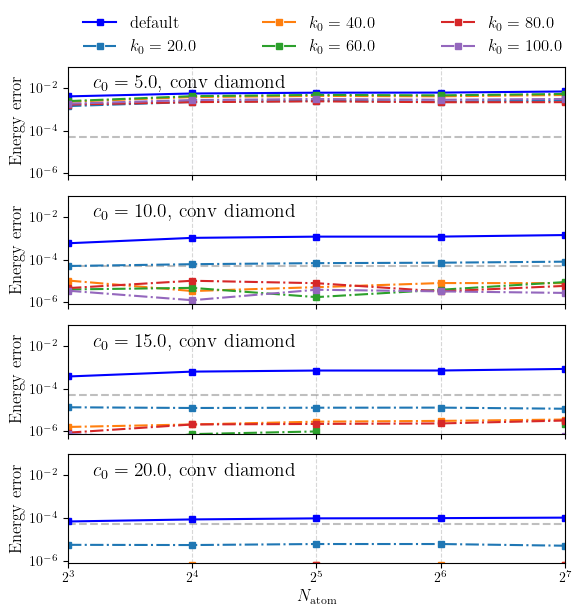

In [255]:
diamond_conv_k = get_info_from_out_log("../work/run-scf-kpt/diamond-conv")
plot_error(diamond_conv_k)

In [256]:
def plot_time(data):
    """
    Plot timing data for different methods (fftisdf, fftdf, gdf).
    
    Parameters:
    -----------
    data : list of dict
        Raw data containing timing information for different methods
    """
    import matplotlib.pyplot as plt
    import numpy
    
    # Process the data to separate by method
    dd = [d for d in data if d["method"] == "fftisdf-jy" and d["ncpu"] == 1 and 
          d.get("k0", None) is not None and d.get("c0") == 10.0 and d.get("k0") == 40.0]
    dd = sorted(dd, key=lambda x: x["kmesh"])
    
    df = [d for d in data if d["method"] == "fftdf" and d["ncpu"] == 1]
    df = sorted(df, key=lambda x: x["kmesh"])
    
    dg = [d for d in data if d["method"] == "gdf" and d["ncpu"] == 1]
    dg = sorted(dg, key=lambda x: x["kmesh"])
    
    fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
    
    # Common setup
    titles = ["Build time (s)", "J time (s)", "K time (s)"]
    time_keys = ["t_build", "t_vj", "t_vk"]
    colors = ["b", "g", "r"]
    markers = ["s", "s", "s"]
    
    natm = dd[0]["natm"]
    
    for i, (ax, title, time_key) in enumerate(zip(axs, titles, time_keys)):
        ax.set_ylabel(title, fontsize=12)
        ax.grid(True, which="major", alpha=0.5, linestyle="--")
        
        # Plot fftisdf data
        x = numpy.array([d["kmesh"] for d in dd])
        y = numpy.array([d[time_key] for d in dd])
        m = numpy.argsort(x)
        x = x[m] * natm
        xx = numpy.log2(x)
        ax.semilogy(xx, y, label="FFTISDF-JY", color=colors[0], linestyle="-", marker=markers[0], markersize=6, base=2)
        
        # Plot fftdf data
        # if not time_key == "t_build":
        x = numpy.array([d["kmesh"] for d in df])
        y = numpy.array([d[time_key] + 1e-2 for d in df])
        if time_key == "t_build":
            y *= 0.0
        m = numpy.argsort(x)
        x = x[m] * natm
        xx = numpy.log2(x)
        ax.semilogy(xx, y, label="FFTDF", color=colors[1], linestyle="-", marker=markers[1], markersize=6, base=2)
        
        # Plot gdf data
        x = numpy.array([d["kmesh"] for d in dg])
        y = numpy.array([d[time_key] + 1e-2 for d in dg])
        m = numpy.argsort(x)
        x = x[m] * natm
        xx = numpy.log2(x)
        ax.semilogy(xx, y, label="GDF", color=colors[2], linestyle="-", marker=markers[2], markersize=6, base=2)
    
    # Set x-axis limits and ticks
    cell = dd[0]["cell"].split("-")
    axs[0].text(0.05, 0.80, f"%s %s" % (cell[1], cell[0]), transform=axs[0].transAxes, fontsize=14)
    xx = [i for i in range(3, 8)]
    axs[-1].set_xticks(xx)
    axs[-1].set_xticklabels([r"$2^{%d}$" % i for i in xx])
    axs[-1].set_xlim(xx[0], xx[-1])
    axs[-1].set_xlabel(r"$N_{\mathrm{atom}}$", fontsize=12)
    
    # Add legend to the top plot
    axs[0].legend(
        loc="upper left",
        bbox_to_anchor=(0, 1.3),
        ncol=3, fontsize=12,
        frameon=False, columnspacing=4.0
    )
    
    fig.tight_layout()
    plt.show()
    
    # return fig, axs

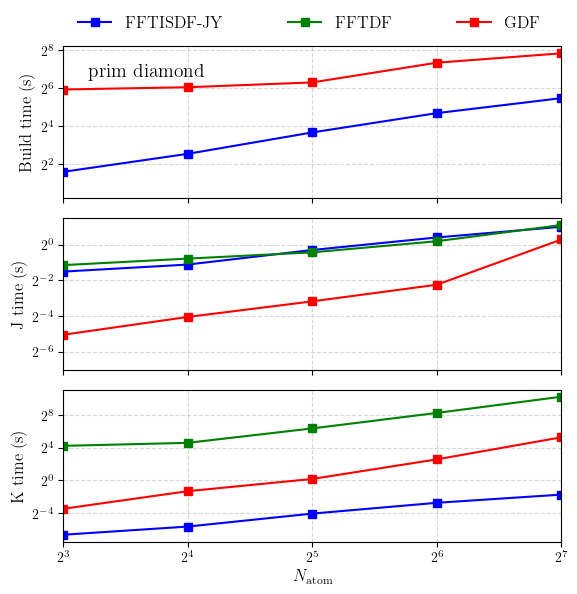

In [257]:
plot_time(diamond_prim_k)

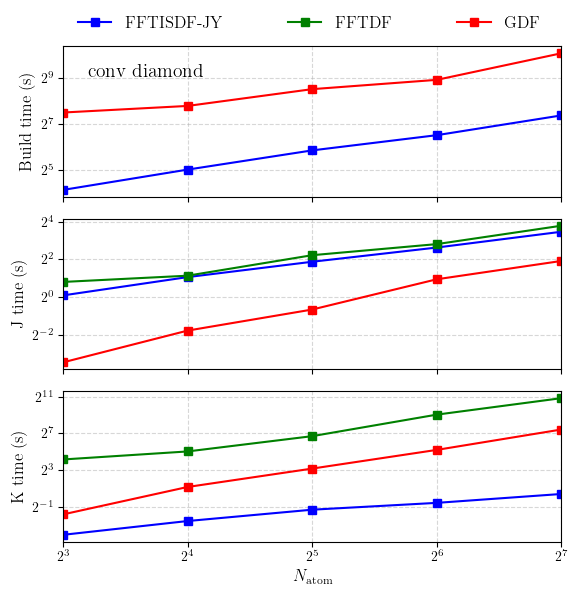

In [258]:
plot_time(diamond_conv_k)